## Часть 1 - предобработка видеофайла для обучения

количество кадров в файле CNTRL.mp4 длительностью 5 минут с помощью библиотеки OpenCV

In [8]:
import cv2
import os
from ultralytics import YOLO

In [1]:
# Загрузка видеофайла
video = cv2.VideoCapture("CNTRL.mp4")

# Получение общего количества кадров
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Вывод количества кадров
print("Количество кадров в видеофайле:", total_frames)

# Освобождение ресурсов
video.release()

Количество кадров в видеофайле: 7509


В идеале надо аннотировать каждый кадр, что очень трудозатратно. Поэтому для совсем пробного варианта выберем каждый 75-й кадр (а потом уже за каждую секунду - каждый 25 кадр). Соответственно - получаем короткое видео.

In [2]:
# Имя и путь к исходному видеофайлу
video_path = "CNTRL.mp4"

# Шаг для выборки кадров
step = 75

# Открытие видеофайла
video = cv2.VideoCapture(video_path)

# Общее количество кадров в видеофайле
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Создание объекта VideoWriter для сохранения выбранных кадров в новом видеофайле
output_video = cv2.VideoWriter("sampled_video.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (int(video.get(3)),int(video.get(4))))

# Чтение и сохранение кадров с шагом 75
for i in range(0, total_frames, step):
    video.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = video.read()
    if ret:
        output_video.write(frame)

# Освобождение ресурсов
video.release()
output_video.release()
cv2.destroyAllWindows()

сохраняем каждый кадр из нового видео "sampled_video.mp4" в отдельный файл JPG. Каждое изображение сохраняется в папке "frames" под именем вида "frame_0.jpg", "frame_1.jpg", и так далее. Этот набор изображений можно будет использовать для аннотирования.

In [4]:
# Открытие видеофайла
video = cv2.VideoCapture("sampled_video.mp4")

# Создание папки для сохранения изображений
if not os.path.exists("frames"):
    os.makedirs("frames")

# Счетчик для именования файлов
frame_counter = 0

while True:
    # Чтение кадра из видео
    ret, frame = video.read()
    if not ret:
        break

    # Сохранение кадра в файл формата JPG
    cv2.imwrite(os.path.join("frames", f"frame_{frame_counter}.jpg"), frame)

    # Увеличение счетчика кадров
    frame_counter += 1

# Освобождение ресурсов
video.release()
cv2.destroyAllWindows()

Нужно сделать аннотирование (отметить СТРОПЫ на кадрах) ранее сохраненных кадров в Roboflow для получения базы data.yaml и дообучить YOLOv8 на этой базе, чтобы получить веса веса дообученной модели.

## Часть 2 - обучение модели

In [ ]:
## ЗДЕСЬ ДОЛЖЕН БЫТЬ код обучения 
## Из-за ограниченности ресурсов обучение провели на Colab - ноутбук Gasprom_train-yolov8-keypoint_24042024.ipynb

## Часть 3 - проверка обученной модели

In [9]:
# загрузка YOLO и весов нашей обученной модели
from ultralytics import YOLO
model = YOLO('best_keypoint_24042024.pt')

In [10]:
# проверка работы на одном из изображений
results = model('frames/frame_86.jpg')
print(results)


image 1/1 c:\IDE\PMMO-23_Gasprom\frames\frame_86.jpg: 384x640 1 slings-9Mn6, 1696.1ms
Speed: 105.9ms preprocess, 1696.1ms inference, 25.9ms postprocess per image at shape (1, 3, 384, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'slings-9Mn6'}
obb: None
orig_img: array([[[111, 106,  91],
        [111, 106,  91],
        [111, 106,  91],
        ...,
        [106, 126, 131],
        [106, 126, 131],
        [106, 126, 131]],

       [[111, 106,  91],
        [111, 106,  91],
        [111, 106,  91],
        ...,
        [106, 126, 131],
        [106, 126, 131],
        [106, 126, 131]],

       [[111, 106,  91],
        [111, 106,  91],
        [111, 106,  91],
        ...,
        [107, 126, 131],
        [107, 126, 131],
        [107, 126, 131]],

       ...,

       [[  0,  10,  26],
        [  0,  12,  28],
        [  0,  11,  24],
        ...,
        [  8,  13,  14],
        

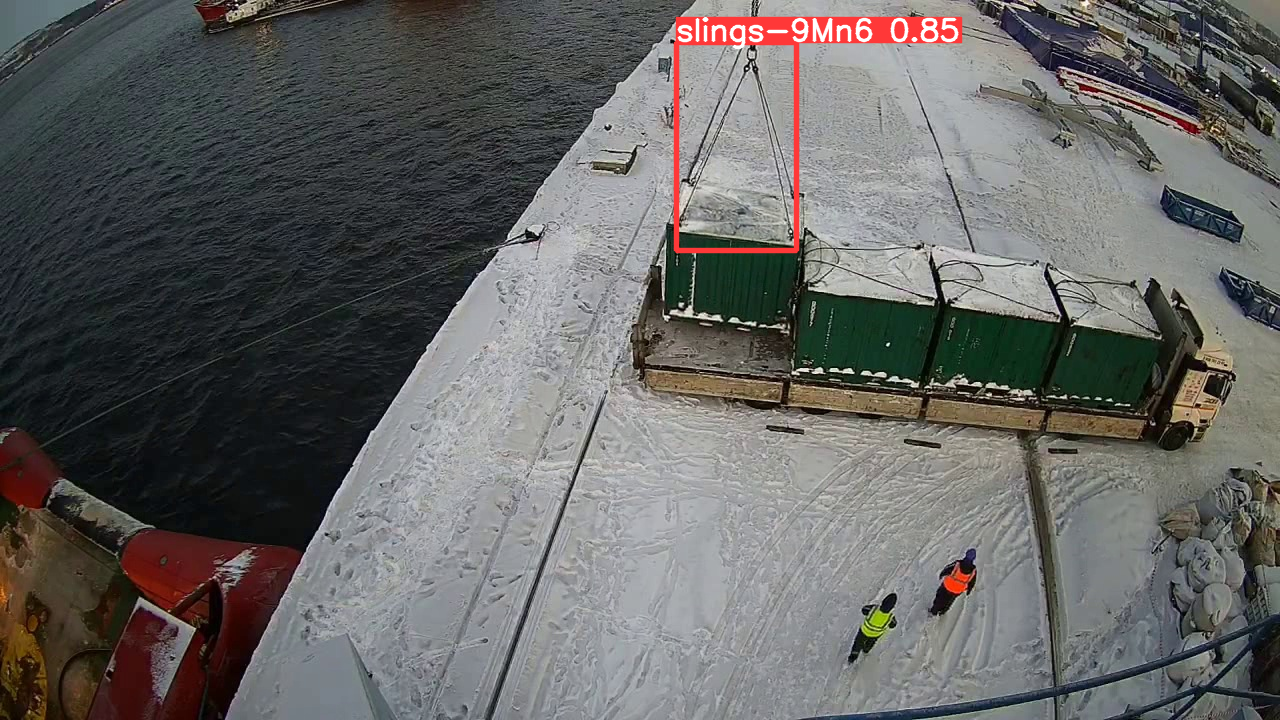

In [11]:
# для визуализации используем библиотеку PIL
from PIL import Image

r = results[0]
im_array = r.plot()  # график массива предсказаний в формате BGR (синий, зелёный, красный) на основе массива numpy
im = Image.fromarray(im_array[..., ::-1])  # PIL-изображение в формате RGB
display(im)

## Часть 4 - пример использования обученной модели. Детекция строп и определение угла между ними. 
Использование обученной нами модели на аннотированной базе изображений, взятых из видеофайла заказчика, для детекции строп  и угла между ними на видео

* делаем допущение по геометрии - определяем угол между строп в проекции 2D (безопасность предела допустимого угла определяется тем, что этот угол в проекции больше оригинального угла в 3D, т.е. будем иметь некоторый запас в пределах 10%). Иначе нужно было аннотировать отдельно концы каждой стропы (заложить трудозатраты) - результат не сильно бы изменился.
* ниже код использования нашей модели для детекции строп и определения угла между ними. На каждом кадре видео делаем детекцию объектов строп и рисуем рамки вокруг них (с координатами, вероятностью и величиной угла между стропами). 
* Далее получаем новое видео уже с этой детекцией.
* Подобно этому после получения обученной модели на аннотированной базе по стропам мы запустим эту же обработку и в итоге получим детекцию строп в рамках с координатами (координаты будем сохранять для дальнейшей обработки). 
* В следующем блоке обработаем базу координат, чтобы получить нужные углы.
* В вероятность детекции выводим сверху рамки синим цветом. Значение угла выводим снизу рамки красным цветом. Максимальный угол выводим на печать.

In [18]:
# загрузка необходимых библиотек и модулей
import cv2
import os
import numpy as np
from ultralytics import YOLO
from PIL import Image

# загрузка весов нашей обученной содели
model = YOLO('best_keypoint_24042024.pt')

# для демонстрации используем укороченное видео
video_path = "sampled_video.mp4"                        # Путь к видеофайлу для обработки
cap = cv2.VideoCapture(video_path)                      # Открытие видеофайла для чтения

fps = int(cap.get(cv2.CAP_PROP_FPS))                    # Получение количества кадров в секунду
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))    # Получение ширины кадра
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Получение высоты кадра

# Создание видеофайла для записи результатов
output_video = cv2.VideoWriter("output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

max_angle = 0                       # Инициализация переменной для хранения максимального угла

while True:
    ret, frame = cap.read()         # Чтение кадра из видеофайла
    if not ret:
        break                       # Выход из цикла, если кадры закончились
    
    results = model.predict(frame)  # Предсказание с помощью модели YOLO

    for box in results[0].boxes:
               
        class_id = model.names[box.cls[0].item()]           # Получение имени класса
        cords = [round(x) for x in box.xyxy[0].tolist()]    # Получение координат рамки
        conf = round(box.conf[0].item(), 2)                 # Получение вероятности модели
        
        # Расчет угла
        mid_top_x = (cords[0] + cords[2]) // 2              # x-координата середины верхней стороны рамки
        mid_top_y = cords[1]                                # y-координата верхней стороны рамки
        mid_bottom_left_x = cords[0]                        # x-координата левого нижнего угла рамки
        mid_bottom_right_x = cords[2]                       # x-координата правого нижнего угла рамки
        mid_bottom_y = cords[3]                             # y-координата нижней стороны рамки

        # Вычисление координат центра верхнего ребра и краёв нижнего ребра
        mid_top = np.array([mid_top_x, mid_top_y])                      # Координаты середины верхней стороны рамки
        mid_bottom_left = np.array([mid_bottom_left_x, mid_bottom_y])   # Координаты левого нижнего угла рамки
        mid_bottom_right = np.array([mid_bottom_right_x, mid_bottom_y]) # Координаты правого нижнего угла рамки
        
        # Вычисление векторов от центра верхнего ребра к краям нижнего ребра
        vector_left = mid_bottom_left - mid_top     # Вектор от центра верхнего ребра к левому краю нижнего ребра
        vector_right = mid_bottom_right - mid_top    # Вектор от центра верхнего ребра к правому краю нижнего ребра
        
        # Вычисление длин векторов
        length_left = np.linalg.norm(vector_left)       # Длина левого вектора
        length_right = np.linalg.norm(vector_right)     # Длина правого вектора
        
        # Вычисление угла между векторами с помощью скалярного произведения
        dot_product = np.dot(vector_left, vector_right)         # Скалярное произведение векторов         
        cos_angle = dot_product / (length_left * length_right)  # Косинус угла между векторами
        angle = np.arccos(cos_angle) * 180 / np.pi              # Вычисление угла в градусах
        
        # Округление угла и вывод его под рамкой
        angle = int(round(angle))               # Округление угла
        angle_text = f"{angle} gradus"          # Форматирование текста с углом
        # Вывод текста угла
        cv2.putText(frame, angle_text, (cords[0], cords[3] + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 3)
        
        if abs(angle) > abs(max_angle):
            max_angle = angle           # Обновление максимального угла
        
        # Рисование рамки
        cv2.rectangle(frame, (cords[0], cords[1]), (cords[2], cords[3]), (0, 255, 0), 2) # Рисование прямоугольника
        # Вывод текста класса и вероятности
        cv2.putText(frame, f"{class_id} {conf}", (cords[0], cords[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    output_video.write(frame)       # Запись кадра в выходное видео

cap.release()                       # Освобождение ресурсов, которые использовали при захвате видеофайла
output_video.release()              # Завершение записи видеофайла
cv2.destroyAllWindows()             # Закрытие всех окон OpenCV

print("Максимальный угол:", max_angle)



0: 384x640 (no detections), 2199.6ms
Speed: 100.7ms preprocess, 2199.6ms inference, 17.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 995.3ms
Speed: 10.0ms preprocess, 995.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 slings-9Mn6, 1916.2ms
Speed: 16.0ms preprocess, 1916.2ms inference, 16.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 slings-9Mn6, 936.5ms
Speed: 5.0ms preprocess, 936.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 slings-9Mn6, 1055.0ms
Speed: 6.0ms preprocess, 1055.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 slings-9Mn6s, 1221.7ms
Speed: 3.0ms preprocess, 1221.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 slings-9Mn6, 1375.9ms
Speed: 3.0ms preprocess, 1375.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 slings-9Mn6, 1136.0ms
Speed: 41.9m